In [41]:
# !pip install pycaret-ts-alpha
# ! pip install -U kaleido

In [42]:
from pycaret.regression import *
import plotly.express as px
import shutil
import os
import glob
# import logger
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kaleido

In [43]:
# logger = logging.getLogger()
# logger.setLevel(logging.CRITICAL)

In [44]:
# sheetname='15-Connect Property Water_Plumb'
# data = pd.read_excel(r'data/Copy of claim_count_fc_workbook.xlsx', sheet_name=sheetname)

In [102]:
sheetname='5c_MSA_PIP_out'
data = pd.read_excel(r'auto_coverage_volume2.xlsx', sheet_name=sheetname)

In [103]:
#  Create rnd categorical list
rnd_list=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
rnd_categorical=[]
for i in range(len(data)):
    item = random.choices(rnd_list, k=1)
    rnd_categorical.append(item[0])

In [104]:
data['Series'] = np.arange(1,len(data)+1)
data = data[['Series','Date', 'Year', 'Month', 'Season','Quarter', 'CAT_Season', 'GDP','UNEMP','CPI','USCRUDE','COVIDC','COVIDD','PIF', 'Claim_Volume']]
data.rename(columns={'CAT_Season':'CATSeason'},inplace=True)
data.drop(['Date'], axis=1, inplace=True)
data['random_num_col_should_drop_from_model']= np.random.randint(0,1000,size=(len(data),1))
data['RANDOMcategoricalCOLUMN']=rnd_categorical

In [141]:
def create_start_date(yr,month,day):
    start_date_cal=str(yr)+'-'+str(month)+'-'+str(day)
    return start_date_cal

start_date_series_point=49 #/*40 cut off since Covid lockdown, 25 for Connect with PIF*/
test_date_series_point=61 #/*49,52,55*/
end_date_series_point=62

test_cutoff_date=create_start_date(data[data['Series'] == test_date_series_point].Year.values[0],data[data['Series'] == test_date_series_point].Month.values[0],'01')
train_cutoff_date=create_start_date(data[data['Series'] == start_date_series_point].Year.values[0],data[data['Series'] == start_date_series_point].Month.values[0],'01')
end_cutoff_date=create_start_date(data[data['Series'] == end_date_series_point].Year.values[0],data[data['Series'] == end_date_series_point].Month.values[0],'01')

print('train_cutoff_date:',train_cutoff_date,'\ntest_cutoff_date:',test_cutoff_date,'\nend_cutoff_date:',end_cutoff_date)

train_cutoff_date: 2021-1-01 
test_cutoff_date: 2022-1-01 
end_cutoff_date: 2022-2-01


In [142]:
# train = data[(data['Year'] < 2021)] #&(data['Year'] > 2018)]
# test = data[(data['Year'] == 2021)]


train =  data[(data['Series'] < test_date_series_point) & (data['Series'] >= start_date_series_point) ] #& (data['Series'] > 24)
test = data[(data['Series'] >= test_date_series_point) & (data['Series'] <= end_date_series_point)]

data2 = data[(data['Series'] >= start_date_series_point)&(data['Series'] <= end_date_series_point)] #]
# check shape
train.shape, test.shape

((12, 16), (2, 16))

In [143]:
train.head()

,Series,Year,Month,Season,Quarter,CATSeason,GDP,UNEMP,CPI,USCRUDE,COVIDC,COVIDD,PIF,Claim_Volume,random_num_col_should_drop_from_model,RANDOMcategoricalCOLUMN
48,49,2021,1,Winter,1,No,21.98,6.3,110.638,53.60,6088996.0,97815.0,171045.0,108.0,89,0
49,50,2021,2,Winter,1,No,21.75,6.2,111.030,60.46,2343267.0,65661.0,170033.0,81.0,652,0
50,51,2021,3,Spring,1,No,22.46,6.0,111.719,63.83,1797797.0,32299.0,168782.0,105.0,321,7
51,52,2021,4,Spring,2,No,22.65,6.1,112.579,62.95,1837247.0,20791.0,167457.0,114.0,543,12
52,53,2021,5,Spring,2,No,22.74,5.8,113.305,66.40,898896.0,16532.0,166524.0,117.0,825,14


In [144]:
test

,Series,Year,Month,Season,Quarter,CATSeason,GDP,UNEMP,CPI,USCRUDE,COVIDC,COVIDD,PIF,Claim_Volume,random_num_col_should_drop_from_model,RANDOMcategoricalCOLUMN
60,61,2022,1,Winter,1,No,23.564747,3.855968,116.970415,77.839513,6.877471e+06,35398.839994,159321.0000,114.0,606,7
61,62,2022,2,Winter,1,No,23.987613,3.802393,117.802736,86.589215,4.856476e+06,63615.286445,159912.0201,139.0,760,3


In [145]:
setup(
    data = train, 
    test_data = test, 
    target = 'Claim_Volume', 
    fold_strategy = 'timeseries', 
    numeric_features = ['GDP','UNEMP','CPI','USCRUDE','COVIDC','COVIDD','PIF', 'COVIDC','COVIDD','RANDOMcategoricalCOLUMN','random_num_col_should_drop_from_model'], 
    categorical_features=['Month','Year','Quarter'],
    
    feature_selection=True,
    fold = 4,
    feature_selection_method='classic',
    fold_shuffle=True,
    
    remove_outliers=False,
    ignore_features=['Series'],
    trigonometry_features=False,
    polynomial_features=False,
    transform_target = True, 
    verbose=False,
    silent=True,
#     ordinal_features={'Year':['2019','2020']},
    session_id = 10)

(False,
 True,
 -1,
 'box-cox',
 [('Setup Config',
                                  Description             Value
   0                               session_id                10
   1                                   Target      Claim_Volume
   2                            Original Data          (12, 16)
   3                           Missing Values             False
   4                         Numeric Features                 9
   5                     Categorical Features                 5
   6                         Ordinal Features             False
   7                High Cardinality Features             False
   8                  High Cardinality Method              None
   9                    Transformed Train Set          (12, 19)
   10                    Transformed Test Set           (2, 19)
   11                      Shuffle Train-Test              True
   12                     Stratify Train-Test             False
   13                          Fold Generator   TimeS

In [146]:
top_x_model=8
best_baseline_models = compare_models(sort = 'MAPE',n_select=top_x_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,12.7046,368.1315,16.5699,-5.9807,0.1266,0.0910,0.3375
rf,Random Forest Regressor,13.2090,340.1383,17.1002,-7.7682,0.1302,0.0976,0.5650
ada,AdaBoost Regressor,14.0000,283.5000,15.3272,-2.0073,0.1115,0.1027,0.0225
omp,Orthogonal Matching Pursuit,14.0584,400.4574,16.3439,-1.9068,0.1176,0.1090,0.4825
lr,Linear Regression,13.9257,285.7480,15.1960,-2.5083,0.1139,0.1104,0.0100
xgboost,Extreme Gradient Boosting,16.8462,544.6736,21.2137,-9.5551,0.1568,0.1314,10.5075
lightgbm,Light Gradient Boosting Machine,18.5568,581.4461,22.0316,-13.0413,0.1708,0.1317,0.0200
dummy,Dummy Regressor,18.5568,581.4461,22.0316,-13.0413,0.1708,0.1317,0.0075
llar,Lasso Least Angle Regression,18.5568,581.4461,22.0316,-13.0413,0.1708,0.1317,0.5900
et,Extra Trees Regressor,17.7910,523.4106,20.8010,-6.2707,0.1537,0.1342,0.1000


In [147]:
model_names=pull()
model_names

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,12.7046,368.1315,16.5699,-5.9807,0.1266,0.0910,0.3375
rf,Random Forest Regressor,13.2090,340.1383,17.1002,-7.7682,0.1302,0.0976,0.5650
ada,AdaBoost Regressor,14.0000,283.5000,15.3272,-2.0073,0.1115,0.1027,0.0225
omp,Orthogonal Matching Pursuit,14.0584,400.4574,16.3439,-1.9068,0.1176,0.1090,0.4825
lr,Linear Regression,13.9257,285.7480,15.1960,-2.5083,0.1139,0.1104,0.0100
xgboost,Extreme Gradient Boosting,16.8462,544.6736,21.2137,-9.5551,0.1568,0.1314,10.5075
lightgbm,Light Gradient Boosting Machine,18.5568,581.4461,22.0316,-13.0413,0.1708,0.1317,0.0200
dummy,Dummy Regressor,18.5568,581.4461,22.0316,-13.0413,0.1708,0.1317,0.0075
llar,Lasso Least Angle Regression,18.5568,581.4461,22.0316,-13.0413,0.1708,0.1317,0.5900
et,Extra Trees Regressor,17.7910,523.4106,20.8010,-6.2707,0.1537,0.1342,0.1000


In [148]:
drop_model_list=['knn','dummy','br','llar','omp','huber','xgboost']
for x in drop_model_list:
    try:
        model_names=model_names.drop(index=(x))
        print('dropped ',x,' from model_list')
    except:
        print('pass')
    

pass
dropped  dummy  from model_list
dropped  br  from model_list
dropped  llar  from model_list
dropped  omp  from model_list
dropped  huber  from model_list
dropped  xgboost  from model_list


In [149]:
model_names

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,12.7046,368.1315,16.5699,-5.9807,0.1266,0.0910,0.3375
rf,Random Forest Regressor,13.2090,340.1383,17.1002,-7.7682,0.1302,0.0976,0.5650
ada,AdaBoost Regressor,14.0000,283.5000,15.3272,-2.0073,0.1115,0.1027,0.0225
lr,Linear Regression,13.9257,285.7480,15.1960,-2.5083,0.1139,0.1104,0.0100
lightgbm,Light Gradient Boosting Machine,18.5568,581.4461,22.0316,-13.0413,0.1708,0.1317,0.0200
et,Extra Trees Regressor,17.7910,523.4106,20.8010,-6.2707,0.1537,0.1342,0.1000
gbr,Gradient Boosting Regressor,18.5400,449.7364,20.7982,-20.4571,0.1605,0.1409,0.0175
ridge,Ridge Regression,18.5216,701.6051,23.4319,-10.0900,0.1725,0.1437,0.0100
en,Elastic Net,19.7995,901.2739,23.5238,-2.7842,0.1847,0.1445,0.0100
lasso,Lasso Regression,20.6146,935.4480,24.6003,-3.8708,0.1921,0.1517,0.0100


# Create or recreate directory

In [150]:
#Create New Directory for each Sheet
dir = sheetname
if os.path.exists(dir):
    shutil.rmtree(dir)

try:
    os.makedirs(os.path.join('viz_selection',dir,'testing_compare'))
except:
    shutil.rmtree(os.path.join('viz_selection',dir,'testing_compare'))
    os.makedirs(os.path.join('viz_selection',dir,'testing_compare'))

    
try:
    os.makedirs(os.path.join('viz_selection',dir,'feature_importance_before_feature_selection'))
except:
    shutil.rmtree(os.path.join('viz_selection',dir,'feature_importance_before_feature_selection'))
    os.makedirs(os.path.join('viz_selection',dir,'feature_importance_before_feature_selection'))
    
    
try:
    os.makedirs(os.path.join('viz_selection',dir,'feature_importance_feature_selected'))
except:
    shutil.rmtree(os.path.join('viz_selection',dir,'feature_importance_feature_selected'))
    os.makedirs(os.path.join('viz_selection',dir,'feature_importance_feature_selected'))
        
try:
    os.makedirs(os.path.join('viz_selection',dir,'permutation_fi_train'))
except:
    shutil.rmtree(os.path.join('viz_selection',dir,'permutation_fi_train'))
    os.makedirs(os.path.join('viz_selection',dir,'permutation_fi_train'))
        
try:
    os.makedirs(os.path.join('viz_selection',dir,'permutation_fi_test'))
except:
    shutil.rmtree(os.path.join('viz_selection',dir,'permutation_fi_test'))
    os.makedirs(os.path.join('viz_selection',dir,'permutation_fi_test'))

# Generate top x models
-----
<details><summary>Click here for the steps</summary>
    
    step1 generate models (generate models with features importance)
    step2 select features above rnd
    step3 regenerate models by updating training data
    step4 generate models with features selected (generate forecasts) 
    
</details>

In [151]:
def feature_specific(f):
    try:
        string=f[:f.index("_")]
    except:
        string=f
    return string

def rnd_order_cal(x):
    if x in model_feature_importance['Feature'].to_list():
        rnd_order=model_feature_importance.index[model_feature_importance['Feature']==x][0]-1
    else:
        rnd_order=max(model_feature_importance.index)
    return rnd_order

In [152]:
target_feature_name='Claim_Volume'
force_added_feature=['PIF','Year','Quarter','Month']
str_feature=['Season','CATSeason']
categorical_features=['Month','Year','Quarter']

In [153]:
for i in range(0,min(top_x_model,len(model_names))):
    
    #  initiate the model for another model run
    
    train2=train.copy()
    test2=test.copy()
    data3=data2.copy()
    
    initiate_setup = setup(
    data = train, 
    test_data = test, 
    target = 'Claim_Volume', 
    fold_strategy = 'timeseries', 
    numeric_features = ['GDP','UNEMP','CPI','USCRUDE','COVIDC','COVIDD','PIF', 'COVIDC','COVIDD','RANDOMcategoricalCOLUMN','random_num_col_should_drop_from_model'], 
    categorical_features=['Month','Year','Quarter'],
        
    feature_selection=True,
    fold = 4,
    feature_selection_method='classic',
    fold_shuffle=True,
        
    remove_outliers=False,
    ignore_features=['Series'],
    trigonometry_features=False,
    polynomial_features=False,
    transform_target = True, 
    verbose=False,
    silent=True,
#     ordinal_features={'Year':['2019','2020']},
    session_id = 10)
    
    #  end of model initiation
    
    model_name=model_names.index[i]
    model_create_all_feature = create_model(model_name)
    print(i,model_name)
    
    
# Move feature importance plot to *_before feature selection directory
    try:
        plt_path=plot_model(model_create_all_feature,plot = 'feature_all',save=True)
        shutil.move(plt_path,'./viz_selection/%s/feature_importance_before_feature_selection/feature_importance_%s_%s.png' %(sheetname,model_name,str(i)))
    except:
        print('no feature importance all generated')

# Get list of feature of each initiated model
    try: #model_create_all_feature.feature_names_in_
        model_feature_importance=pd.DataFrame({'Feature':get_config('X_train').columns, 'Value' : model_create_all_feature.feature_importances_}).sort_values(by='Value', ascending=False)
    except:
        model_feature_importance=pd.DataFrame({'Feature':get_config('X_train').columns, 'Value' : abs(model_create_all_feature.coef_[0])}).sort_values(by='Value', ascending=False)
#         Nest model feature importance
#         try: # model_create_all_feature.feature_names_in_
#             model_feature_importance=pd.DataFrame({'Feature':get_config('X_train').columns, 'Value' : abs(model_create_all_feature.coef_[0])}).sort_values(by='Value', ascending=False)
#         except: # for boost model cannot find feature name from object attributes
#             model_feature_importance=pd.DataFrame({'Feature':get_config('X_train').columns, 'Value' : model_create_all_feature.feature_importances_}).sort_values(by='Value', ascending=False)

    model_feature_importance.reset_index(inplace=True)
    
# Find order of the rnd within the feature importance list
#     rnd_order=rnd_order_cal('random_num_col_should_drop_from_model')
    rnd_order_num=rnd_order_cal('random_num_col_should_drop_from_model')
    rnd_order_cat=rnd_order_cal('RANDOMcategoricalCOLUMN')
    rnd_order=min(rnd_order_num,rnd_order_cat)
    

# Truncate the feature list by exclude features below rnd
    feature_list=pd.DataFrame(model_feature_importance.truncate(after=rnd_order)['Feature'])

# create the feature pick list by adding force added features (user define or model requirement)
    feature_list_pick=list(set(feature_list['Feature'].apply(lambda x:feature_specific(x)).unique().tolist()+force_added_feature)) #/*Force add PIF here*/
    train2=train[feature_list_pick+[target_feature_name]]
    test2=test[feature_list_pick+[target_feature_name]]

# create numeric feature list
    feature_list_pick_numeric=feature_list_pick
    for feature in str_feature:
        if feature in feature_list_pick_numeric: 
            feature_list_pick_numeric.remove(feature)
    for feature in categorical_features:
        if feature in feature_list_pick_numeric: 
            feature_list_pick_numeric.remove(feature)

    print('feature_list_pick_numeric: ',feature_list_pick_numeric)

# reset the model by picking the features selected
    model_set= setup(
                        data = train2, 
                        test_data = test2, 
                        target = 'Claim_Volume', 
                        fold_strategy = 'timeseries', 
                        numeric_features = feature_list_pick_numeric, 
                        categorical_features=['Month','Year','Quarter'],
#                         group_features=['']
        
                        feature_selection=False,
                        fold = 4,
                        feature_selection_method='classic',
                        fold_shuffle=True,
        
                        remove_outliers=False,
                        trigonometry_features=False,
                        polynomial_features=False,
                        transform_target = True, 
                        silent=True,
#                         ordinal_features={'Year':['2017','2018','2019','2020']},
                        verbose=False,
                        session_id = 10)
    
    print('model name: ',model_name)
    model_create_feature_select = create_model(model_name)
    print(i,model_name, 'regenerated after drop less importance features.')
    
    pfi_train_path=interpret_model(model_create_feature_select,use_train_data=True,plot='pfi',save=True)
    pfi_train_path.write_image('./viz_selection/%s/permutation_fi_train/pfi_train_%s_%s.png' %(sheetname,model_name,str(i)))
    
    pfi_train_path=interpret_model(model_create_feature_select,use_train_data=False,plot='pfi',save=True)
    pfi_train_path.write_image('./viz_selection/%s/permutation_fi_test/pfi_test_%s_%s.png' %(sheetname,model_name,str(i)))
    
    plt_path=plot_model(model_create_feature_select,plot = 'feature_all',save=True)
    shutil.move(plt_path,'./viz_selection/%s/feature_importance_feature_selected/feature_selected_%s_%s.png' %(sheetname,model_name,str(i)))
    
    predictions = predict_model(model_create_feature_select, data=data3)

    # add a date column in the dataset**
    predictions['Date'] = pd.date_range(start=train_cutoff_date, end = end_cutoff_date, freq = 'MS') #'2017-01-01'

    # line plot**
    fig = px.line(predictions, x='Date', y=["Claim_Volume", "Label"], template = 'plotly_dark')

    # add a vertical rectange for test-set separation
    fig.add_vrect(x0=test_cutoff_date, x1=end_cutoff_date, fillcolor="grey", opacity=0.25, line_width=0) #2021-01-01
#     fig.show()
    fig.write_image('./viz_selection/%s/testing_compare/%s_testing_%s.png' %(sheetname,str(i),model_name))

## explore Feature importance

In [154]:
def process(filename: str=None) -> None:
    image = mpimg.imread(filename)
    # <something gets done here>
    plt.figure()
    plt.title(filename.split('/')[-1])
    plt.imshow(image)

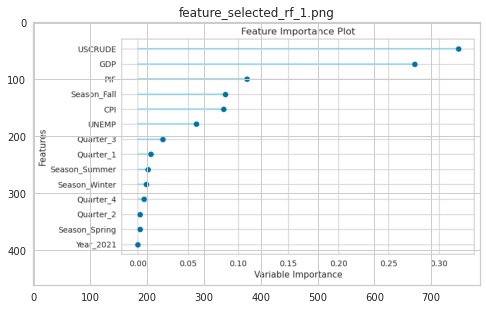

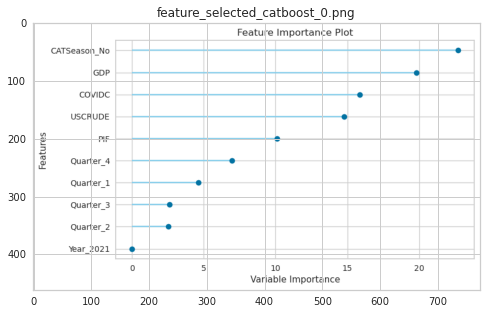

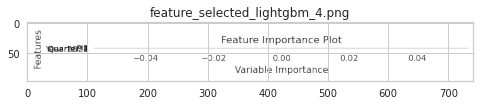

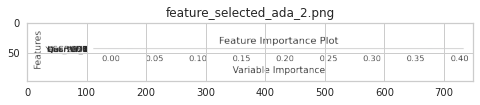

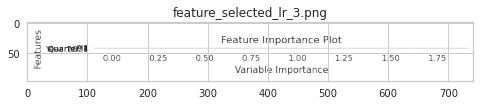

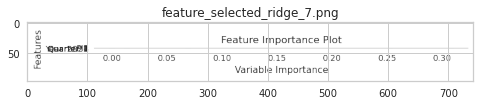

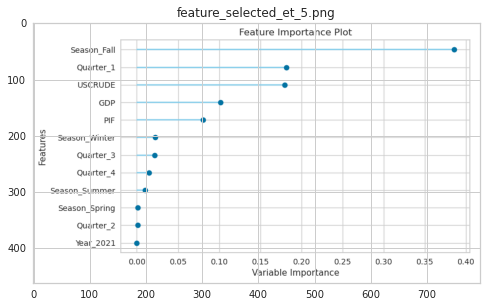

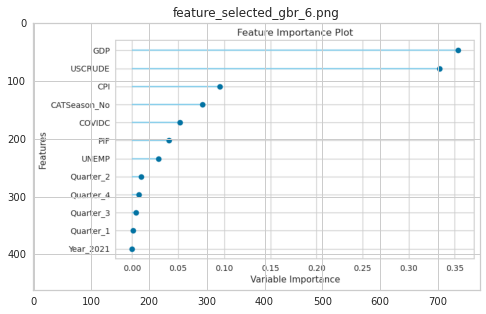

In [155]:
for file in glob.glob(os.path.join(os.getcwd(), 'viz_selection/%s/feature_importance_feature_selected' %(sheetname),'*.png')):
    process(file)

## explore testing data viz

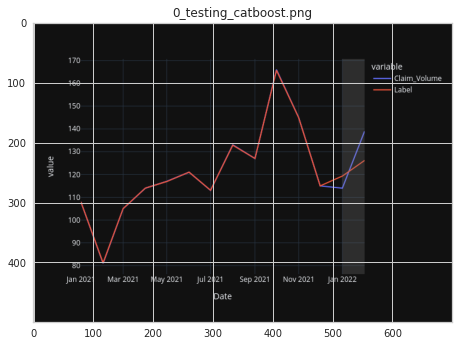

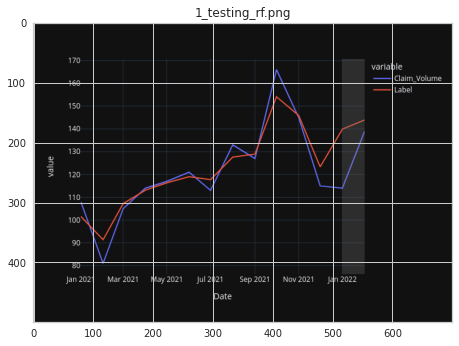

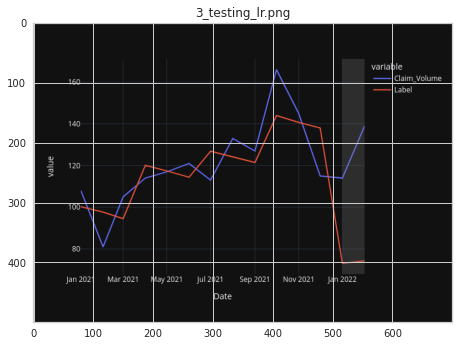

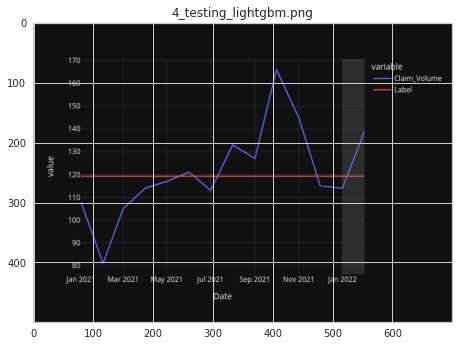

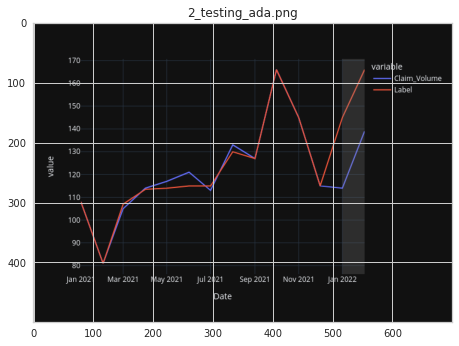

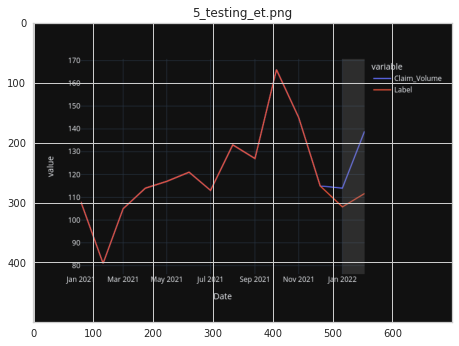

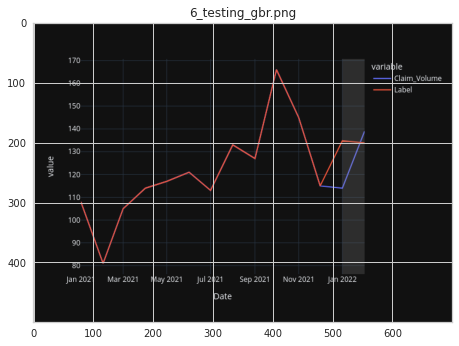

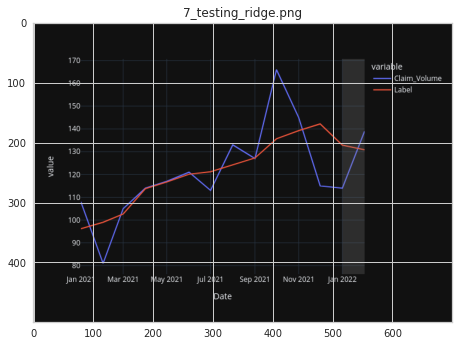

In [156]:
for file in glob.glob(os.path.join(os.getcwd(), 'viz_selection/%s/testing_compare' %(sheetname),'*.png')):
    process(file)

# Model Pick - decision

In [157]:
model_pick=['catboost','rf', 'ada']
model_score=['MAPE']

model_candicates=model_names.loc[model_pick].sort_values(by=model_score)
model_candicates

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,12.7046,368.1315,16.5699,-5.9807,0.1266,0.0910,0.3375
rf,Random Forest Regressor,13.2090,340.1383,17.1002,-7.7682,0.1302,0.0976,0.5650
ada,AdaBoost Regressor,14.0000,283.5000,15.3272,-2.0073,0.1115,0.1027,0.0225


## pick the final model

In [188]:
model_final_pick='catboost'

target_feature_name='Claim_Volume'
force_added_feature=['PIF','Year','Quarter','Month']
str_feature=['Season','CATSeason']
categorical_features=['Month','Year','Quarter']

#  initiate the model for another model run

train2=train.copy()
test2=test.copy()
data3=data2.copy()

# train2.drop(columns=['RANDOMcategoricalCOLUMN'],inplace=True)
# test2.drop(columns=['RANDOMcategoricalCOLUMN'],inplace=True)
# data3.drop(columns=['RANDOMcategoricalCOLUMN'],inplace=True)

initiate_setup = setup(
                data = train, 
                test_data = test, 
                target = 'Claim_Volume', 
                fold_strategy = 'timeseries', 
                numeric_features = ['GDP','UNEMP','CPI','USCRUDE','COVIDC','COVIDD','PIF', 'COVIDC','COVIDD','RANDOMcategoricalCOLUMN','random_num_col_should_drop_from_model'], 
                categorical_features=categorical_features,

                feature_selection=True,
                fold = 4,
                feature_selection_method='classic',
                fold_shuffle=True,

                remove_outliers=False,
                ignore_features=['Series'],
                trigonometry_features=False,
                polynomial_features=False,
                transform_target = True, 
                verbose=False,
                silent=True,
                # ordinal_features={'Year':['2019','2020']},
                session_id = 10)

#  end of model initiation

model_create_all_feature = create_model(model_final_pick)


try: #model_create_all_feature.feature_names_in_
    model_feature_importance=pd.DataFrame({'Feature':get_config('X_train').columns, 'Value' : model_create_all_feature.feature_importances_}).sort_values(by='Value', ascending=False)
except:
    model_feature_importance=pd.DataFrame({'Feature':get_config('X_train').columns, 'Value' : abs(model_create_all_feature.coef_[0])}).sort_values(by='Value', ascending=False)
#         Nest model feature importance
#         try: # model_create_all_feature.feature_names_in_
#             model_feature_importance=pd.DataFrame({'Feature':get_config('X_train').columns, 'Value' : abs(model_create_all_feature.coef_[0])}).sort_values(by='Value', ascending=False)
#         except: # for boost model cannot find feature name from object attributes
#             model_feature_importance=pd.DataFrame({'Feature':get_config('X_train').columns, 'Value' : model_create_all_feature.feature_importances_}).sort_values(by='Value', ascending=False)

model_feature_importance.reset_index(inplace=True)

rnd_order_num=rnd_order_cal('random_num_col_should_drop_from_model')
rnd_order_cat=rnd_order_cal('RANDOMcategoricalCOLUMN')
rnd_order=min(rnd_order_num,rnd_order_cat)

feature_list=pd.DataFrame(model_feature_importance.truncate(after=rnd_order)['Feature'])

feature_list_pick=list(set(feature_list['Feature'].apply(lambda x:feature_specific(x)).unique().tolist()+force_added_feature)) #/*Force add PIF here*/
train2=train2[feature_list_pick+[target_feature_name]]
test2=test2[feature_list_pick+[target_feature_name]]

feature_list_pick_numeric=feature_list_pick
for feature in str_feature:
    if feature in feature_list_pick_numeric: 
        feature_list_pick_numeric.remove(feature)

print('feature_list_pick_numeric: ',feature_list_pick_numeric)

model_set= setup(
                    data = train2, 
                        test_data = test2, 
                        target = 'Claim_Volume', 
                        fold_strategy = 'timeseries', 
                        numeric_features = feature_list_pick_numeric, 
                        categorical_features=categorical_features,
#                         group_features=['']
        
                        feature_selection=False,
                        fold = 4,
                        feature_selection_method='classic',
                        fold_shuffle=True,
        
                        remove_outliers=False,
                        trigonometry_features=False,
                        polynomial_features=False,
                        transform_target = True, 
                        silent=True,
#                         ordinal_features={'Year':['2017','2018','2019','2020']},
                        verbose=False,
                        session_id = 10)

# model_create_feature_select = create_model(model_name)
# print(i,model_name, 'regenerated after drop less importance features.')

picked_model = create_model(model_final_pick)
# evaluate_model(picked_model)
picked_model_score=pull()
picked_model_score=picked_model_score.loc['Mean']

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7.8004,64.8456,8.0527,-15.2114,0.0691,0.0653
1,11.5834,162.2714,12.7386,-0.6227,0.1025,0.0913
2,20.6790,728.8246,26.9968,-0.9167,0.1836,0.1276
3,18.0095,331.0013,18.1934,-0.4711,0.1285,0.1381
Mean,14.5181,321.7357,16.4954,-4.3055,0.1209,0.1056
SD,5.0963,253.5885,7.0455,6.2986,0.0419,0.0290


In [189]:
tuned_model=tune_model(picked_model)

tuned_model_score=pull()
tuned_model_score=tuned_model_score.loc['Mean']

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.5582,47.0105,6.8564,-10.7526,0.0585,0.0548
1,10.5270,120.1880,10.9630,-0.2019,0.0879,0.0841
2,21.1024,817.4607,28.5913,-1.1498,0.1961,0.1288
3,26.4473,753.6631,27.4529,-2.3496,0.2006,0.2128
Mean,16.1587,434.5806,18.4659,-3.6135,0.1358,0.1201
SD,7.9715,352.6557,9.6742,4.1915,0.0635,0.0596


7it [00:00, 325.75it/s]


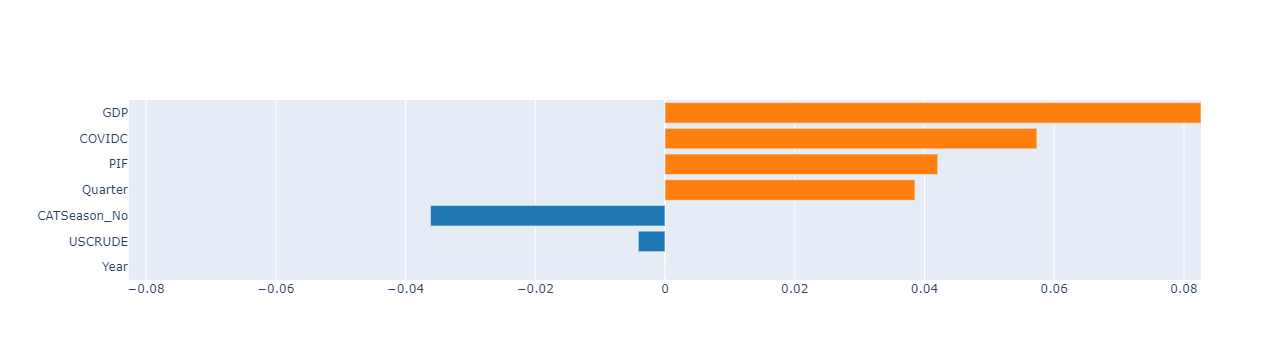

In [190]:
pfi_train_path=interpret_model(picked_model,use_train_data=True,plot='pfi',save=True)
pfi_train_path.write_image('./viz_selection/%s/pfi_train_%s.png' %(sheetname,model_final_pick))
pfi_train_path

7it [00:00, 331.54it/s]


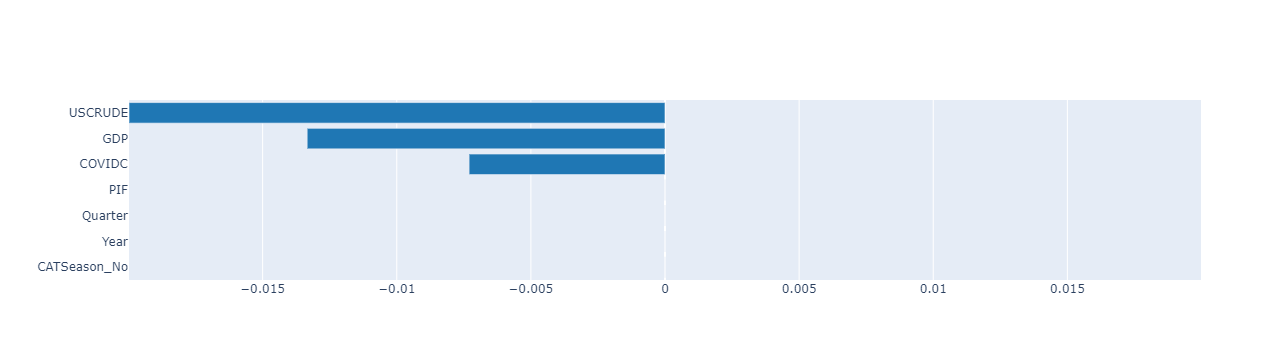

In [191]:
pfi_test_path=interpret_model(picked_model,plot='pfi',seed=10)
pfi_test_path.write_image('./viz_selection/%s/pfi_test_%s.png' %(sheetname,model_final_pick))
pfi_test_path

In [192]:
# model_text_output=['power_transformer_method:',
#         str(picked_model.power_transformer_method),
#         '\npower_transformer_standardize:' ,
#         str(picked_model.power_transformer_standardize),
#         '\nregressor:',
#         str(picked_model.regressor)]
# model_text_output

## pick tuned or original model

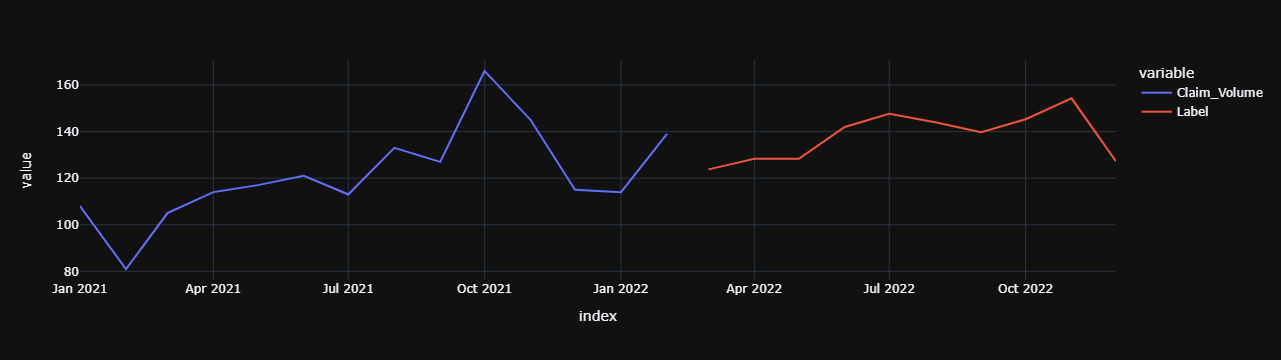

In [193]:
# Pick - tuned_model or picked_model
tuned_or_picked_model = picked_model

# Create prediction file
# future_df = pd.DataFrame(data[data['Year'] == 2022])   
future_df = pd.DataFrame(data[data['Series'] > end_date_series_point])  
predictions_future = predict_model(tuned_or_picked_model, data=future_df) 
concat_df = pd.concat([data3,predictions_future], axis=0)
concat_df_i = pd.date_range(start=train_cutoff_date, end = '2022-12-01', freq = 'MS') #'2017-01-01'
concat_df.set_index(concat_df_i, inplace=True)

concat_df.to_csv(os.path.join(os.getcwd(), 'viz_selection/%s/picked_%s.csv') %(sheetname,model_final_pick))

# Create model score csv
if tuned_or_picked_model==picked_model:
    model_score_output=picked_model_score
else:
    model_score_output=tuned_model_score
    
# Create model info txt
with open('./viz_selection/%s/picked_model_score_%s.txt' %(sheetname,model_final_pick), 'w') as f:
    f.writelines(str(model_score_output))

with open('./viz_selection/%s/candidates_score.txt' %(sheetname), 'w') as f:
    f.writelines(str(model_candicates))


# Save model prediction fig
fig = px.line(concat_df, x=concat_df.index, y=["Claim_Volume", "Label"], template = 'plotly_dark')
fig.show()
fig.write_image('./viz_selection/%s/picked_%s.png' %(sheetname,model_final_pick))

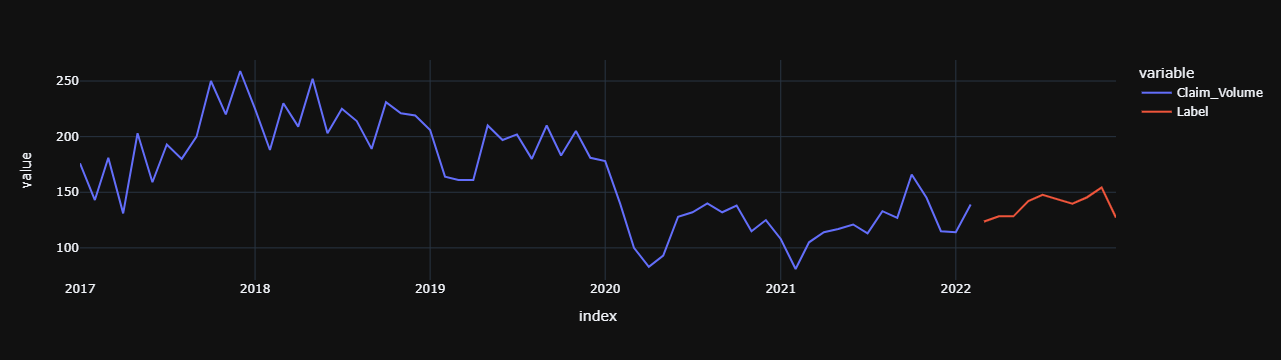

In [194]:
concat_df2 = pd.concat([data[(data['Series'] <= end_date_series_point)],predictions_future], axis=0)
concat_df_i2 = pd.date_range(start='2017-1-1', end = '2022-12-01', freq = 'MS') #'2017-01-01'
concat_df2.set_index(concat_df_i2, inplace=True)

fig = px.line(concat_df2, x=concat_df2.index, y=["Claim_Volume", "Label"], template = 'plotly_dark')
fig.show()
fig.write_image('./viz_selection/%s/add_historical_%s.png' %(sheetname,model_final_pick))

# Permutation Feature Importance

In [195]:
# from sklearn import preprocessing
# from sklearn.linear_model import Ridge

# train_pfi=train2.copy()
# test_pfi=test2.copy()

# le_Season = preprocessing.LabelEncoder()
# le_Season.fit(['Winter', 'Spring', 'Summer', 'Fall'])

# train_pfi['Season'] = le_Season.transform(train_pfi['Season'])
# test_pfi['Season'] = le_Season.transform(test_pfi['Season'])

# model = Ridge(alpha=0.0).fit(train_pfi[['Month', 'Year', 'USCRUDE', 'Season', 'PIF', 'COVIDD', 'Quarter']], train_pfi['Claim_Volume'])

In [196]:
# from sklearn.inspection import permutation_importance
# r = permutation_importance(model, test_pfi[['Month', 'Year', 'USCRUDE', 'Season', 'PIF', 'COVIDD', 'Quarter']], test_pfi['Claim_Volume'],
#                             n_repeats=10,
#                             random_state=0)

In [197]:
# for i in r.importances_mean.argsort()[::-1]:
#      if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#          print(f"{train_pfi.columns[i]:<8}"
#                f"{r.importances_mean[i]:.3f}"
#                f" +/- {r.importances_std[i]:.3f}")

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.41585e-08): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rco